In [ ]:
import os
import zipfile
from google.colab import drive


drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Hocsau/imgs.zip'

extract_path = '/content/dataset'


if not os.path.exists(extract_path):
    print("Đang giải nén..." )
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(" Đã giải nén xong!")
else:
    print(" Dữ liệu đã có sẵn.")


TRAIN_DIR = os.path.join(extract_path, 'imgs', 'train')


if os.path.exists(TRAIN_DIR):
    print(f"Đường dẫn train chuẩn: {TRAIN_DIR}")
    print("Các lớp (class) tìm thấy:", os.listdir(TRAIN_DIR))
else:
    print(f" Vẫn chưa thấy thư mục train tại: {TRAIN_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dữ liệu đã có sẵn.
Đường dẫn train chuẩn: /content/dataset/imgs/train
Các lớp (class) tìm thấy: ['c7', 'c1', 'c6', 'c0', 'c9', 'c5', 'c4', 'c3', 'c8', 'c2']
có thể chạy tiếp các bước sau.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cấu hình tham số
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Tạo generator với tỉ lệ validation 20%
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    validation_split=0.2
)

# Load dữ liệu Train
print("Đang nạp dữ liệu Training...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

# Load dữ liệu Validation
print("Đang nạp dữ liệu Validation...")
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Đang nạp dữ liệu Training...
Found 17943 images belonging to 10 classes.
Đang nạp dữ liệu Validation...
Found 4481 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Xây dựng mô hình
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Cấu hình callback
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_driver_model.keras', save_best_only=True)
]

# Bắt đầu huấn luyện
print("Bắt đầu huấn luyện...")
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Bắt đầu huấn luyện...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 332s 560ms/step - accuracy: 0.2957 - loss: 2.1565 - val_accuracy: 0.7472 - val_loss: 0.9207
Epoch 2/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 288s 512ms/step - accuracy: 0.6039 - loss: 1.1633 - val_accuracy: 0.8023 - val_loss: 0.7144
Epoch 3/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 284s 506ms/step - accuracy: 0.6674 - loss: 0.9886 - val_accuracy: 0.8246 - val_loss: 0.6373
Epoch 4/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 282s 503ms/step - accuracy: 0.6789 - loss: 0.9504 - val_accuracy: 0.8201 - val_loss: 0.6207
Epoch 5/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 287s 512ms/step - accuracy: 0.6865 - loss: 0.9346 - val_accuracy: 0.8465 - val_loss: 0.5432
Epoch 6/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 285s 508ms/step - accuracy: 0.6957 - loss: 0.9000 - val_accuracy: 0.8208 - val_loss: 0.5833
Epoch 7/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 283s 505ms/step - accuracy: 0.6988 - loss: 0.8887 - val_accuracy: 0.8322 - val_loss: 0.5513
Epoch 8/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 284s 506ms/step - accuracy: 0.7003 -

In [ ]:
import shutil
import os

model_filename = 'best_driver_model.keras'

drive_save_path = '/content/drive/MyDrive/Hocsau/best_driver_model.keras'

if os.path.exists(model_filename):
    shutil.copy(model_filename, drive_save_path)
    print(f"Đã sao chép mô hình thành công tới Google Drive: {drive_save_path}")
else:
    print(f"Lỗi: Không tìm thấy file mô hình {model_filename}. Có thể EarlyStopping không được kích hoạt.")

Đã sao chép mô hình thành công tới Google Drive: /content/drive/MyDrive/Hocsau/best_driver_model.keras


In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

def run_inference(model_path, dataset_root, output_name):
    # Định nghĩa đường dẫn
    test_img_dir = os.path.join(dataset_root, 'imgs', 'test')
    template_path = os.path.join(dataset_root, 'sample_submission.csv')

    if not os.path.exists(model_path):
        print(f"Error: Model file {model_path} not found.")
        return

    # Kiểm tra file csv mẫu, nếu không có thì tự quét thư mục
    if os.path.exists(template_path):
        print(f"Using template: {template_path}")
        template_df = pd.read_csv(template_path)
        file_list = template_df['img'].tolist()
    else:
        print("Template CSV not found. Scanning test directory...")
        if not os.path.exists(test_img_dir):
            print(f"Error: Test directory {test_img_dir} not found.")
            return
        # Lấy danh sách ảnh và sắp xếp
        file_list = sorted([f for f in os.listdir(test_img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    if not file_list:
        print("No images found.")
        return

    # Tạo dataframe
    infer_df = pd.DataFrame({'filename': file_list})

    # Cấu hình Generator
    infer_gen = ImageDataGenerator(rescale=1./255)
    data_flow = infer_gen.flow_from_dataframe(
        dataframe=infer_df,
        directory=test_img_dir,
        x_col='filename',
        y_col=None,
        target_size=(224, 224),
        class_mode=None,
        batch_size=64,
        shuffle=False
    )

    # Nạp mô hình và thực thi
    print(f"Loading model from {model_path}...")
    network = load_model(model_path)

    print(f"Processing predictions for {len(file_list)} images...")
    predictions = network.predict(data_flow, verbose=1)

    # Đóng gói kết quả
    class_cols = [f'c{i}' for i in range(10)]
    result_df = pd.DataFrame(predictions, columns=class_cols)
    result_df.insert(0, 'img', file_list)

    # Lưu file
    result_df.to_csv(output_name, index=False)
    print(f"Completed. Results saved to {output_name}")

if __name__ == "__main__":
    run_inference(
        model_path='best_driver_model.keras',
        dataset_root='/content/dataset',
        output_name='submission_final.csv'
    )

Template CSV not found. Scanning test directory...
Found 79726 validated image filenames.
Loading model from best_driver_model.keras...
Processing predictions for 79726 images...
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 281s 215ms/step
Completed. Results saved to submission_final.csv


In [ ]:
from google.colab import files
if os.path.exists('submission_final.csv'):
    files.download('submission_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading model from best_driver_model.keras...
Running predictions and generating visualization...


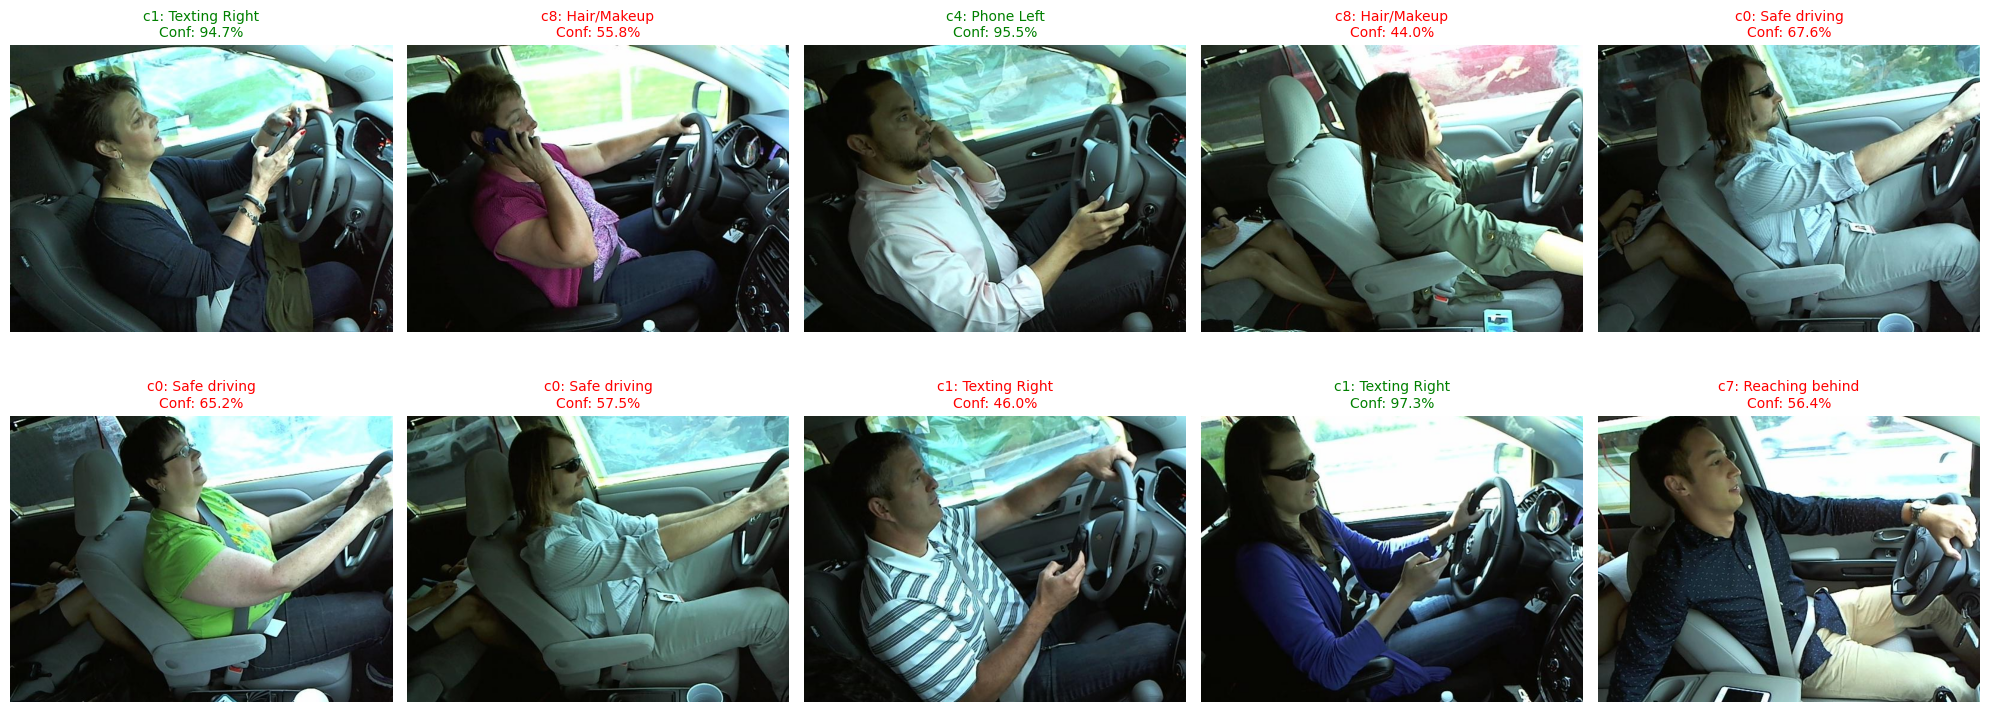

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model


MODEL_PATH = 'best_driver_model.keras'
TEST_DIR = '/content/dataset/imgs/test'
IMG_SIZE = (224, 224)
CLASS_LABELS = {
    0: 'c0: Safe driving', 1: 'c1: Texting Right', 2: 'c2: Phone Right',
    3: 'c3: Texting Left', 4: 'c4: Phone Left', 5: 'c5: Radio',
    6: 'c6: Drinking', 7: 'c7: Reaching behind', 8: 'c8: Hair/Makeup',
    9: 'c9: Talking to passenger'
}

def predict_and_visualize_random(model_path, test_dir, num_images=10):
    if not os.path.exists(model_path):
        print(f"Model file {model_path} not found.")
        return

    if not os.path.exists(test_dir):
        print(f"Test directory {test_dir} not found.")
        return

    # Nạp mô hình
    print(f"Loading model from {model_path}...")
    model = load_model(model_path)

    # Lấy danh sách và chọn ngẫu nhiên ảnh
    all_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.png'))]
    if len(all_files) < num_images:
        print(f"Not enough images in test dir. Found {len(all_files)}")
        selected_files = all_files
    else:
        selected_files = random.sample(all_files, num_images)

    # Thiết lập khung vẽ
    plt.figure(figsize=(20, 8))
    rows = 2
    cols = 5

    print("Running predictions and generating visualization...")
    for i, filename in enumerate(selected_files):
        img_path = os.path.join(test_dir, filename)

        # 1. Load ảnh gốc để hiển thị
        original_img = load_img(img_path)

        # 2. Tiền xử lý cho mô hình (resize và chuẩn hóa)
        img_processed = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img_processed)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # 3. Dự đoán
        predictions = model.predict(img_array, verbose=0)
        pred_idx = np.argmax(predictions[0])
        confidence = np.max(predictions[0])

        label_text = CLASS_LABELS.get(pred_idx, f"Class {pred_idx}")

        # 4. Vẽ lên subplot
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(original_img)
        # Tiêu đề: Lớp dự đoán và độ tin cậy (%)
        title_color = 'green' if confidence > 0.7 else 'red' # Màu đỏ nếu độ tin cậy thấp
        plt.title(f"{label_text}\nConf: {confidence:.1%}", color=title_color, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Thực thi hàm
if __name__ == "__main__":
    predict_and_visualize_random(MODEL_PATH, TEST_DIR, num_images=10)

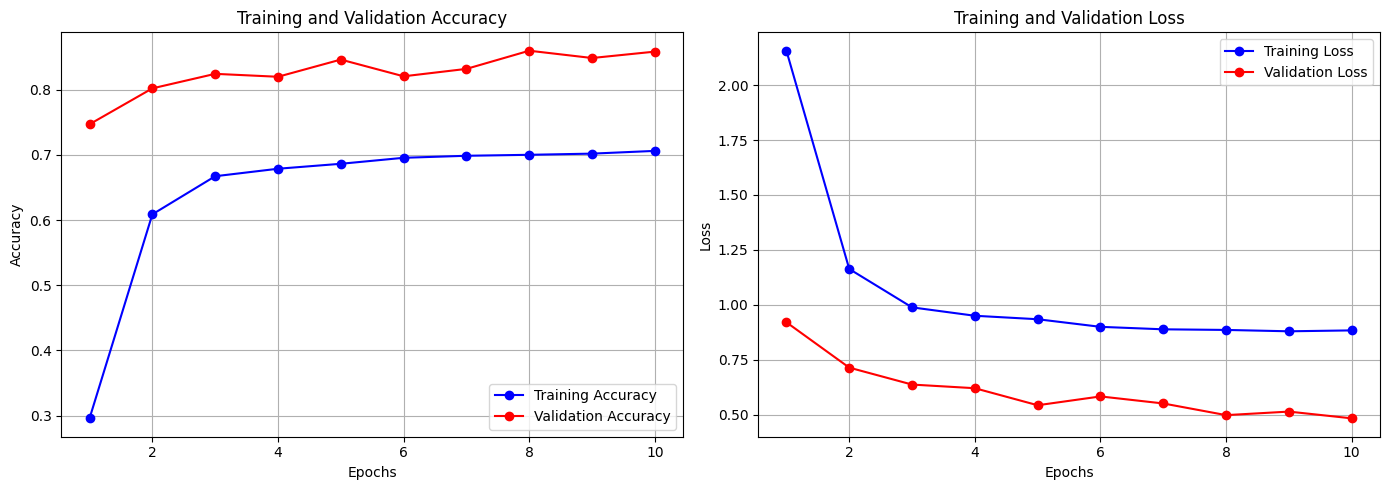

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Số liệu từ nhật ký huấn luyện của bạn (Epoch 1-10)
epochs = range(1, 11)
acc = [0.2957, 0.6089, 0.6674, 0.6789, 0.6865, 0.6957, 0.6988, 0.7003, 0.7021, 0.7063]
val_acc = [0.7472, 0.8023, 0.8246, 0.8201, 0.8465, 0.8208, 0.8322, 0.8601, 0.8489, 0.8587]
loss = [2.1565, 1.1633, 0.9886, 0.9504, 0.9346, 0.9000, 0.8887, 0.8859, 0.8797, 0.8838]
val_loss = [0.9207, 0.7144, 0.6373, 0.6207, 0.5432, 0.5833, 0.5513, 0.4982, 0.5143, 0.4836]

plt.figure(figsize=(14, 5))

# Biểu đồ Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Biểu đồ Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()